# INSTRUCTIONS

#### Part 1: Computing the optimal speed from the optimal racing line
- Part 1 of this notebook takes the optimal racing line, which can be generated with Race-Line-Calculation.ipynb ([GitHub](https://github.com/cdthompson/deepracer-k1999-race-lines)), and generates the optimal speed for each point on the racing line
- Input: .py file with 2D array containing optimal racing line: 2 columns (x,y)
- Output: .py file with 2D array: 4 columns (x,y,speed,expected time). This array can be inserted into the reward function
- Note: The last point of the racing line is deleted because it is the same point as the first one

#### Part 2: Computing the Action Space
- Part 2 of this notebook takes the optimal racing line and speed, and uses K-Means with Gaussian Noise infused data, to calculate the action space

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math
import matplotlib.pyplot as plt

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [39]:
# Hyperparams to be adjusted based on track

LOOK_AHEAD_POINTS = 5
MIN_SPEED = 1.0
MAX_SPEED = 2.0

# do clustering for discrete action space
N_CLUSTER = 12-1

In [40]:
# Path of the optimal racing line (.npy file)
fpath = "artifacts/raceline_thunder_hill_pro.npy"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
racing_track = racing_track.tolist()[:-1]

# Helper functions for Part 1 and Part 2

In [41]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [np.round(min(v, max_speed), 1)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

# Part 1: Calculate optimal speed

- Change ```LOOK_AHEAD_POINTS``` to influence how many points the algorithm looks ahead (the higher, the sooner the car will start to break)
- Change ```MIN_SPEED``` and ```MAX_SPEED``` to fit the track and model !

In [42]:
# Calculate optimal speed
velocity = optimal_velocity(track=racing_track, 
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed: 1.2913857271051552


#### Visualization

Constant multiple for optimal speed: 1.2913857271051552


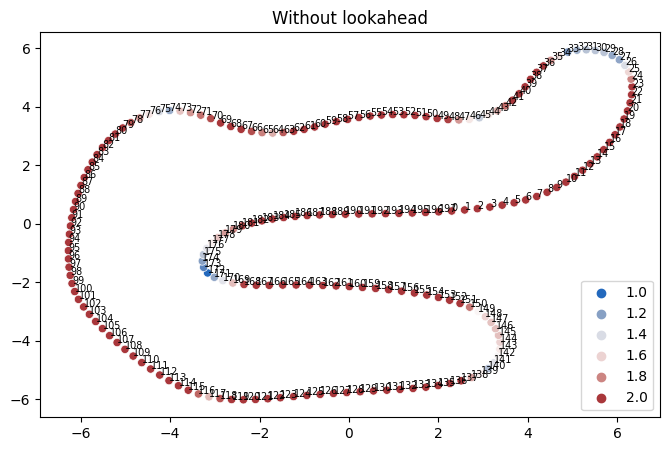

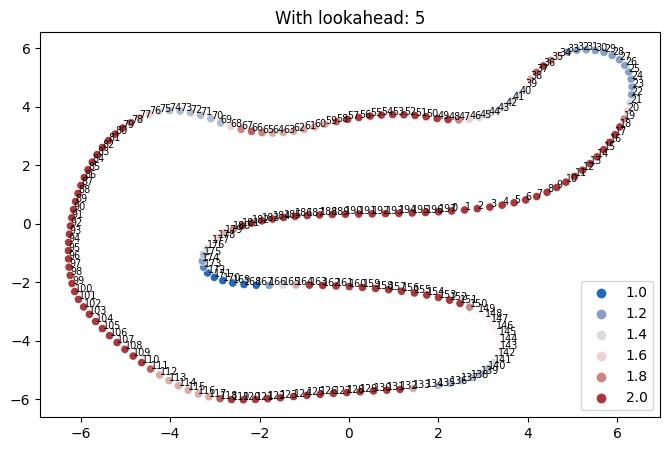

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
for index, (i_x, i_y) in enumerate(zip(x, y)):
    ax.text(i_x, i_y, f'{index}', color="black", size='x-small')   
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")
                          
fig, ax = plt.subplots(figsize=(8, 5))
for index, (i_x, i_y) in enumerate(zip(x, y)):
    ax.text(i_x, i_y, f'{index}', color="black", size='x-small') 
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

In [44]:
pd.set_option('display.max_rows', None)
temp = pd.DataFrame(enumerate(velocity))
temp.columns = ["waypoints", "speed"]
temp.loc[118] = [118, 4]
temp = temp.sort_values("speed")
temp


,waypoints,speed
172,172,1.0
170,170,1.0
169,169,1.0
168,168,1.0
167,167,1.0
171,171,1.0
173,173,1.1
23,23,1.2
24,24,1.2
25,25,1.2


In [45]:
above_three_five = sorted(temp.loc[temp.speed >= 3.5, "waypoints"].tolist())
above_three = sorted(temp.loc[(3 <= temp.speed) & (temp.speed < 3.5), "waypoints"].tolist())
above_two_five = sorted(temp.loc[(2.5 <= temp.speed) & (temp.speed < 3), "waypoints"].tolist())
above_two = sorted(temp.loc[(2 <= temp.speed) & (temp.speed < 2.5), "waypoints"].tolist())

In [46]:
print("1. waypoints where car should run at speed >= 3.5:")
print(above_three_five)
print("2. waypoints where car should run at speed >= 3:")
print(above_three)
print("3. waypoints where car should run at speed >= 2.5:")
print(above_two_five)
print("2. waypoints where car should run at speed >= 2:")
print(above_two)

1. waypoints where car should run at speed >= 3.5:
[118]
2. waypoints where car should run at speed >= 3:
[]
3. waypoints where car should run at speed >= 2.5:
[]
2. waypoints where car should run at speed >= 2:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 36, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]


#### Calculate distance and optimal time between each racing point

In [47]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)
    
time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 30.84679291950139 s


## Append everything together and save to .txt file

In [48]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

In [49]:
racing_track_everything = [[j if index != 2 else round(j, 1) for index, j in enumerate(i)] for i in racing_track_everything]

In [50]:
# Write to txt file
with open(f'artifacts/speed.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

In [51]:
racing_track_everything

[[2.29768, 0.43983, 2.0, 0.14652],
 [2.58628, 0.47559, 2.0, 0.1454],
 [2.87119, 0.51983, 2.0, 0.14416],
 [3.15156, 0.57414, 2.0, 0.14279],
 [3.42629, 0.64043, 2.0, 0.14131],
 [3.69397, 0.72104, 2.0, 0.13978],
 [3.95271, 0.81877, 2.0, 0.13829],
 [4.19987, 0.93718, 2.0, 0.13703],
 [4.43113, 1.0813, 2.0, 0.13624],
 [4.64835, 1.24586, 2.0, 0.13626],
 [4.85261, 1.42779, 2.0, 0.13677],
 [5.04477, 1.62474, 2.0, 0.13758],
 [5.22513, 1.83523, 2.0, 0.1386],
 [5.3939, 2.05795, 2.0, 0.13972],
 [5.55125, 2.29164, 2.0, 0.14086],
 [5.69686, 2.53539, 2.0, 0.14197],
 [5.83043, 2.78811, 2.0, 0.14292],
 [5.95155, 3.04859, 2.0, 0.14363],
 [6.05944, 3.31562, 2.0, 0.144],
 [6.15312, 3.58787, 1.8, 0.15995],
 [6.23007, 3.864, 1.6, 0.17916],
 [6.28743, 4.14184, 1.4, 0.20265],
 [6.32214, 4.41835, 1.2, 0.23223],
 [6.33095, 4.68963, 1.2, 0.22619],
 [6.31065, 4.95105, 1.2, 0.2185],
 [6.25823, 5.19718, 1.2, 0.20971],
 [6.17091, 5.42122, 1.2, 0.20038],
 [6.04713, 5.61415, 1.2, 0.19101],
 [5.88788, 5.76237, 1.2, 0.18

# Part 2: Calculate Optimal Action Space

In [52]:
# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1) # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    radius.append(circle_radius(coords))

# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

# Calculate steering with + and -
dist_wheels_front_back = 0.165 # meters
steering = []
for i in range(len(racing_track)):
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    steering.append(steer)
    
# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity":velocity,
                            "steering":steering})

In [53]:
all_actions.sort_values("velocity")

,velocity,steering
171,1.0,-10.455313
170,1.0,-7.821605
169,1.0,-5.777128
168,1.0,-4.030727
167,1.0,-2.610216
172,1.0,-15.971950
173,1.1,-13.270248
23,1.2,3.897319
24,1.2,4.872417
25,1.2,6.221430


In [54]:
unique_velocities = ', '.join(sorted([str(val) for val in all_actions["velocity"].unique()]))
print(unique_velocities)


1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0


In [55]:
velocity_indices = {}

# Iterate over unique velocity values
for velocity in all_actions["velocity"].unique():
    # Find indices where the velocity value occurs
    indices = all_actions.index[all_actions["velocity"] == velocity].tolist()
    # Store the indices in the dictionary
    velocity_indices[velocity] = indices

# Print the dictionary
for velocity, indices in velocity_indices.items():
    print(f"Velocity {velocity}: {indices}")

Velocity 2.0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 36, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]
Velocity 1.8: [19, 35, 47, 65, 67, 150, 180]
Velocity 1.6: [20, 34, 46, 68, 76, 178]
Velocity 1.4: [21, 40, 41, 42, 43, 44, 45, 75, 141, 165, 176]
Velocity 1.2: [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 166, 174]
Velocity 1.9: [37, 58, 66, 78, 111, 118]
Velocity 1.7: [38, 59, 60, 61, 62, 63, 64, 77, 112, 113, 114, 115, 116, 117, 133, 164, 179]
Velocity 1.5: [39, 134, 142, 143, 144, 145, 146, 147, 148, 149, 177]
Velocity 1.3: [69, 70, 71, 72, 73, 74, 135, 136, 137, 138, 139, 140, 175]
Velocity 1.0: [167, 

Text(0.5, 1.0, 'With lookahead: 5')

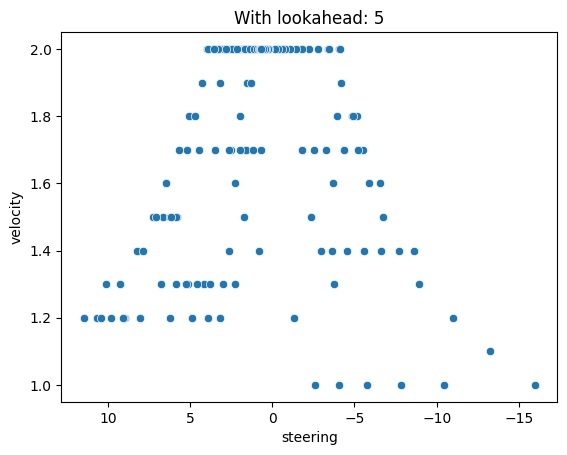

In [56]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")

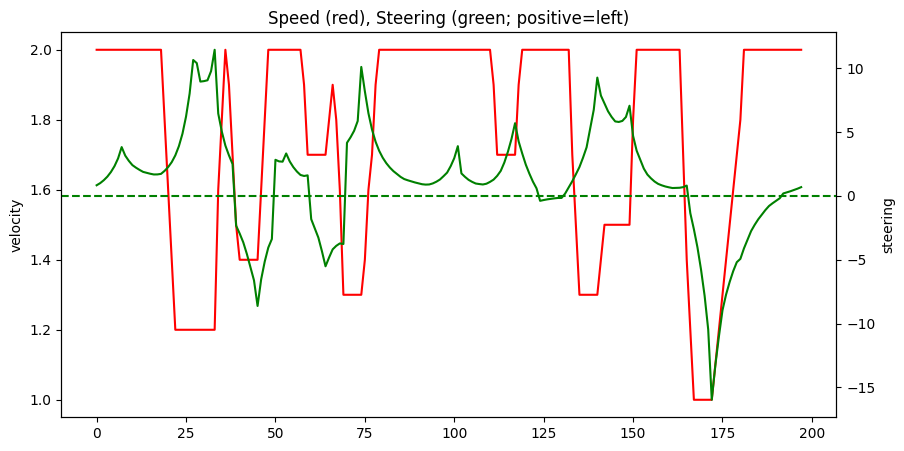

In [57]:
# Visualize all actions
plt.figure(figsize=(10, 5))
sns.lineplot(data=all_actions["velocity"], color="r")
ax2 = plt.twinx()
sns.lineplot(data=all_actions["steering"], color="g", ax=ax2)
plt.axhline(0, ls='--', color="g")
a = plt.title("Speed (red), Steering (green; positive=left)")

In [58]:
all_actions["steering"].max()

11.449773722759087

#### Calculate Action Space with K-Means and Resampling each point with normal distribution

<Axes: ylabel='Density'>

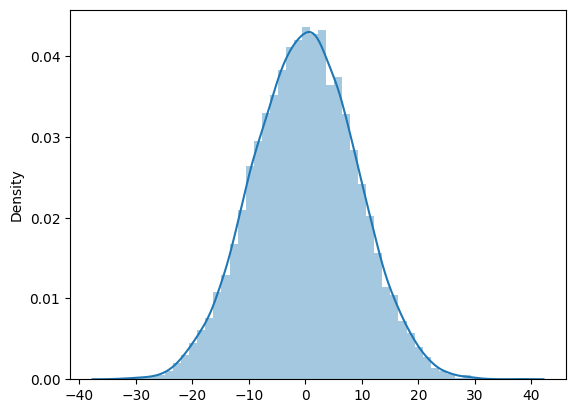

In [59]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)
steering_sd
sns.distplot(np.random.normal(0,steering_sd,10000))

<Axes: ylabel='Density'>

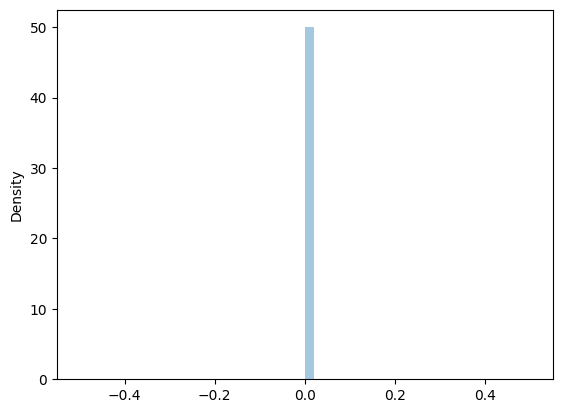

In [60]:
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)
velocity_sd
sns.distplot(np.random.normal(0,velocity_sd,10000))

In [61]:
all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)
    
# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so 
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]
    
# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)


# Display actions shape
all_actions_norm.shape

(116842, 2)

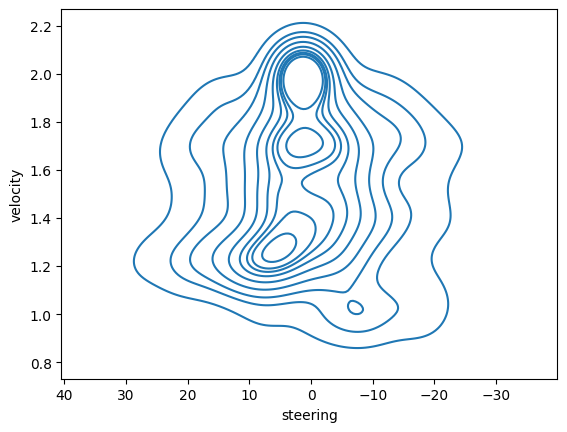

In [62]:
all_actions_norm_less = all_actions_norm.sample(frac=0.01).reset_index(drop=True) # sample bc less compute time
ax = sns.kdeplot(x=all_actions_norm_less["steering"],y=all_actions_norm_less["velocity"])
ax.invert_xaxis()

In [63]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), 
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
model = MiniBatchKMeans(n_clusters=N_CLUSTER).fit(X_minmax)

# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(np.round(X_minmax_fit.inverse_transform(model.cluster_centers_), 1), 
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so 
# it cannot steer enough to get on racing line
# manual_actions = pd.DataFrame({"velocity":[MIN_SPEED, MIN_SPEED],"steering":[30, -30]})
manual_actions = pd.DataFrame({"velocity":[MIN_SPEED],"steering":[30]})

X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()

In [64]:
X_centroids

,velocity,steering
0,1.8,-6.7
1,1.3,0.0
2,1.4,-9.4
3,1.7,7.4
4,1.7,-7.9
5,1.1,-18.4
6,1.2,14.1
7,2.0,1.1
8,1.5,8.0
9,1.0,-2.6


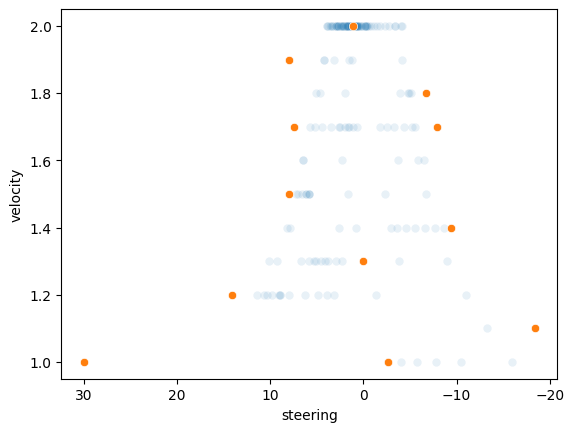

In [65]:
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

*Note: Action space can be different every time it is computed because of randome resampling with gaussian noise and also because of the random seed with K-Means. Therefore, try out multiple iterations until you are happy with the result*

#### Output as JSON format

In [66]:
# Output JSON format
action_space_for_json = action_space_e[["steering","velocity"]].copy()
    
action_space_for_json = action_space_for_json
action_space_for_json.columns = ["steering_angle","speed"]
action_space_for_json["index"] = action_space_for_json.index
action_space_for_json.sort_values(by=['speed'], inplace=True)
json_text = action_space_for_json.to_json(orient="records", lines=False)

action_space_for_json

,steering_angle,speed,index
9,-2.6,1.0,9
11,30.0,1.0,11
5,-18.4,1.1,5
6,14.1,1.2,6
1,0.0,1.3,1
2,-9.4,1.4,2
8,8.0,1.5,8
3,7.4,1.7,3
4,-7.9,1.7,4
0,-6.7,1.8,0


In [67]:
action_space_for_json.sort_values(by=['steering_angle'])

,steering_angle,speed,index
5,-18.4,1.1,5
2,-9.4,1.4,2
4,-7.9,1.7,4
0,-6.7,1.8,0
9,-2.6,1.0,9
1,0.0,1.3,1
7,1.1,2.0,7
3,7.4,1.7,3
8,8.0,1.5,8
10,8.0,1.9,10


In [68]:
with open(f'actions.txt', 'w') as f:
    f.write(json_text)

In [136]:
22 % 10 

2

In [142]:
import numpy as np

# Load the waypoints array
waypoints = np.load(fpath)

# Define thresholds for left and right lanes based on x-coordinate
left_threshold = -2.0
right_threshold = 2.0

# Initialize lists to store indices for each lane
left_lane = []
center_lane = []
right_lane = []

# Iterate over each waypoint
for i, waypoint in enumerate(waypoints):
    x, y = waypoint
    
    # Determine which lane the waypoint belongs to
    if x < left_threshold:
        left_lane.append(i)
    elif x > right_threshold:
        right_lane.append(i)
    else:
        center_lane.append(i)

# Print the generated lists
print("Left Lane Indices:", left_lane)
print("Center Lane Indices:", center_lane)
print("Right Lane Indices:", right_lane)


Left Lane Indices: [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]
Center Lane Indices: [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]
Right Lane Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 197, 198]
